In [1]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
import time
import pandas as pd
import math
from scipy.spatial import distance
from scipy.stats import mode
from pyproj import Proj,transform
import seaborn as sns
import copy
from scipy import sparse
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
v84 = Proj(proj="latlong",towgs84="0,0,0",ellps="WGS84")
v36 = Proj(proj="latlong", k=0.9996012717, ellps="airy", towgs84="446.448,-125.157,542.060,0.1502,0.2470,0.8421,-20.4894")
vgrid = Proj(init="world:bng")

In [5]:
Data=pd.read_csv("All_data.txt",sep = '\t', header = 0)

In [6]:
Copy1 = pd.read_csv('All_data.txt', sep = '\t', header = 0)

In [7]:
copy2 = Copy1.values
true_cattle =  copy.deepcopy(copy2[:,3])
true_sheep =  copy.deepcopy(copy2[:,13])
cattle = copy2[:,3]
sheep = copy2[:,13]

In [8]:
xcoord = Data['xcoord'].values
ycoord = Data['ycoord'].values

In [9]:
joinedinput = np.column_stack((xcoord, ycoord))

In [21]:
N = len(Data)
N

6083

In [11]:
farm_cost = np.zeros(N)
for i in range(0,N):
    farm_cost[i] = 150*sheep[i] + 150*cattle[i]

Data['cost'] = farm_cost

In [12]:
equipment_list = Data['equipment'].values
shares_water_list = Data['water'].values
shares_grazing_list = Data['grazing'].values
shares_milk_list = Data['milk'].values
shares_vet_list = Data['vet'].values
contact_animal_list = Data['contact_animal'].values
contact_human_list = Data['contact_people'].values

In [13]:
#parameters
#tr = np.random.negative_binomial(1, 1/2, N) #Draw immune periods (1 day)
tr = 2*np.ones(N)
        
psi = 0.00657
# psi = 2.5
nu = 1.99*(10**(-4.8))
xi = 4.65
zeta = 2.80
chi = 0.403
phi = 0.799
rho = 0.000863


epsilon = np.zeros(N)
s = np.random.negative_binomial(50, 50/55, N) #Draw latent periods (5 days)
r = np.random.negative_binomial(30, 30/38, N) #Draw infectious periods (8 days)
q = np.random.negative_binomial(2*28, 2*28/(4*28), N) #Draw immune periods (2 months)
v = np.random.negative_binomial(6*28, 6*28/(12*28))
# r = np.random.negative_binomial(8, 8/16, N)

### Call sparse matrices for attributes
Need to have row, col, data saved in format given in function (`Attributes_sparse_matrices.ipynb`). You either need to run the function `def sparse_matrix(name, sparse_type)` or if you've already done this, just simply load the name.npz file.

In [22]:
#once saved files
shares_equipment = sparse.load_npz('Sparse_Matrices/shares_equipment_sparse_subset.npz')
shares_water = sparse.load_npz('Sparse_Matrices/shares_water_sparse_subset.npz')
shares_grazing = sparse.load_npz('Sparse_Matrices/shares_grazing_sparse_subset.npz')
shares_milk = sparse.load_npz('Sparse_Matrices/shares_milk_sparse_subset.npz')
shares_vet = sparse.load_npz('Sparse_Matrices/shares_vet_sparse_subset.npz')
contact_animal = sparse.load_npz('Sparse_Matrices/contact_animal_sparse_subset.npz')
contact_human = sparse.load_npz('Sparse_Matrices/contact_human_sparse_subset.npz')

In [23]:
[a1, a2, a3,a4,a5,a6,a7] = (1/7)*np.ones(7)

transmission_matrix = (a1*shares_equipment+
 a2*shares_water+
 a3*shares_grazing + 
 a4*shares_milk + 
 a5*shares_vet + 
 a6*contact_animal
 + a7*contact_human)

In [24]:
del shares_equipment
del shares_water
del shares_grazing
del shares_vet
del contact_animal
del contact_human

In [25]:
transmission_matrix += a4*shares_milk

In [26]:
del shares_milk

# Functions
##### UNITS: 
distance units are in km/100!!!

So 1km = 0.01

In [27]:
def kerneldist(dist):
    return psi/(psi**2 + dist**2)

### The main code (stochastic discrete-time model):
#### matrix A:
- `A[:,0]` - index of farm (a farm is only added into the matrix when the farm is infected or if its vaccinated)
- `A[:,1]` - time a farm is infected (time unit is days)
- `A[:,2] = s` - length of time/period a farm is exposed for  (average 4 days - negative binomial distribution)
- `A[:,3]  = r` - length of time/period a farm is infectious for (average 8 days - NB dist)
- `A[:,4] = tr` - length of time/period a farm is waiting before triggering vaccines (constant 2 days) 
- `A[:,5] = q` - length of time/period a farm is naturally immue for (average 2 months - NB dist) 
- `A[:,6] = end_q` - time at which a farm becomes susceptible again
- `A[:,7] = t_vac` - time at which a farm is vaccinated
- `A[:,8] = v` - length of time/period a farm is immune for, induced from vaccines (average 6 months - NB dist)
- `A[:,9] = end_v` - time at which vaccine immunity ends

#### matrix I:
- `I == 0` - susceptible farm
- `I == 1` - exposed farm
- `I == 2` - infectious farm
- `I == 3` - vaccinated farm
- `I == 4` - immune farm

In [58]:
def fmd_model(df, n, tmax, num_initial, Capacity,λ, μ, prob_sheep, s, r, tr, q, trans_M,efficacy, ring_vac, ring_cover, farm_cost):
    cattle = copy.deepcopy(df['cattle'].values).astype(int)
    sheep = copy.deepcopy(df['sr'].values).astype(int)
    t = 0
    cost = np.zeros(n)
    A = np.zeros(shape = (n, 10))
    A[:,0] = -1 
    I = np.zeros(n)
    vac = np.zeros(n)
    
    cumInf = np.zeros(tmax)
    numInf = np.zeros(tmax)
    endemic = 0
    
    
    indent = 1
    for k in range(num_initial):
        if k ==0:
            initial = random.randint(0,n-1)
            I[initial] = 1
            A[initial, ] = [initial, 0, s[initial], r[initial], tr[initial], q[initial], 0,0,  0,0]
        else:
            initial2 = (initial + indent)%N
            I[initial2] = 1
            A[initial2, ] = [initial2, 0, s[initial2], r[initial2], tr[initial2], q[initial2], 0, 0, 0, 0]
            indent +=1 
            
    infect_cow = np.zeros(n)
    infect_sheep = np.zeros(n)
    
    
    susceptind = [i for i in range(np.size(I)) if I[i] ==0]
    exposedind = [i for i in range(np.size(I)) if I[i] == 1]
    infectind = [i for i in range(np.size(I)) if I[i]==2]
    vaccineind = [i for i in range(np.size(I)) if I[i]==3]
    immuneind = [i for i in range(np.size(I)) if I[i] ==4]
    
#     time_plot=[0]
    Inf=[len(infectind)]
    Sus = [len(susceptind)]
    Exp = [len(exposedind)]
    Imm = [len(immuneind)]
    Vac = [len(vaccineind)]
    
    Dose = []
    VAC = []
    travelled = []
    
    while t < tmax:
        t = t+1
        print(t)
        infNum = 0
        
        ################################### WITHIN FARM INFECTION ####################################
        for farm in infectind:
                Num_livestock = infect_cow[farm] + infect_sheep[farm]
                inf1 = 1-((1-λ)**Num_livestock) 
                for animals in range(int(cattle[farm]+sheep[farm])):
                    p_beta = np.random.uniform(0,1)
                    if (p_beta<inf1) and Num_livestock<=sheep[farm]+cattle[farm]:
                        if (random.random() < prob_sheep and sheep[farm]>=1 and infect_sheep[farm]<sheep[farm]):
                            infect_sheep[farm] += 1
                        elif (cattle[farm]>=1 and infect_cow[farm]<cattle[farm]):
                            infect_cow[farm] +=1
        
        ################################# BETWEEN FARM INFECTION  #####################################

        ###############################################################################################
        ######################################### ATTRIBUTES ##########################################
        ###############################################################################################
        Attribute_matrix = trans_M.copy()
        beta = np.zeros(n)
        beta1 = nu*(xi*(cattle-infect_cow)**chi + (sheep-infect_sheep)**chi)
        beta3 = zeta*(infect_cow)**chi + infect_sheep**chi
        beta2 = sparse.diags(beta3, shape = (n, n))
        

        Attribute_matrix = sparse.csr_matrix.dot(Attribute_matrix, beta2)

        for j in range(0,n):
            a = Attribute_matrix[j, I ==2]
            dist = np.array([math.sqrt(sum((joinedinput[j] - i)**2))/(100000) for i in joinedinput[I==2]])

            b = kerneldist(dist)
        
            beta[j] = beta1[j]*sparse.csr_matrix.dot(a,b)

        prob_inf = (1 - np.exp(-beta))
        unif = np.random.uniform(0, 1, n)
        
        cattle[I==4] = 0
        cattle[I==3] = 0
        sheep[I ==4] = 0
        sheep[I==3] = 0
        prob_inf[I==3] = 0
        prob_inf[I==4] =0 
        ### immunity ###
        for i in range(0,n):
            if (unif[i] <= prob_inf[i] and I[i] == 0):
                cattle[i] = true_cattle[i]
                sheep[i] = true_sheep[i]
                I[i] =  1
                A[i, ] = [i, t, s[i], r[i], tr[i], q[i], 0, 0,0,0]
        
        ###################################### EXPOSED TO INFECTIOUS ############################################

        inf = A[:,0][A[:,1] + A[:,2] == t]

        I[inf.astype(np.int64)] = 2


        ####################### UPDATE NUMBER OF INFECTED ANIMALS WITHIN AN INFECTIOUS FARM #####################

        for i in inf: 
            i = int(i)
            if (random.random() < (sheep[i]/(sheep[i] +cattle[i])) and sheep[i]>=1 and infect_sheep[i]<sheep[i]):
                infect_sheep[i] += 1
            elif (cattle[i]>=1 and infect_cow[i]<cattle[i]):
                infect_cow[i] +=1
        
        ########################################### RING VACCINATION ###########################################

        trig = A[:,0][A[:,1] + A[:,2] + A[:,4] == t] #trigger vaccines
        RingVac = ring_vac/100
        for i in trig:
            i = int(i)
            dist = np.array([math.sqrt(sum((joinedinput[i] - joinedinput[j])**2))/(100000) for j in range(n)])
            n_vac = [k for k in range(n) if dist[k] <RingVac]
            index=list(np.where(np.random.uniform(0,1,len(n_vac))<ring_cover*np.ones(len(n_vac)))[0])
            ind_vac=list(np.asarray(n_vac)[index])
            
            for j in range(len(ind_vac)):
                m = ind_vac[j]
                if A[m,7] == 0:
                    VAC = np.append(VAC, m)
                    travelled.append(dist[m])
                    
        VAC, indices = np.unique(np.array(VAC, dtype=np.int), return_inverse=True)
        VAC = VAC[indices]
        if len(VAC) > 0:
            VAC = VAC.astype(np.int64)
        if len(VAC)>Capacity:
            cost[VAC[0:Capacity]] += farm_cost[VAC[0:Capacity]]

            for j in range(len(VAC[0:Capacity])):
                m = VAC[j]
                A[m,0] = m
                A[m,7] = t
                if (I[m] == 0):

                    if np.random.uniform(0,1) <efficacy:
                        A[m, 8] = np.random.negative_binomial(6*28, 6*28/(12*28))
                        A[m,9] = A[m,8] + t
                        I[m] = 3
                        cattle[m] = 0
                        sheep[m] = 0
                elif (I[m] == 3):
                    if np.random.uniform(0,1) < efficacy:
                        immunity = np.random.negative_binomial(6*28, 6*28/(12*28))
                        if (A[m,9]) < (immunity+t):
                            A[m,8] = immunity
                            A[m, 9] = immunity +t
                        else:
                            A[m,8] = A[m,9] - t
                elif (I[m] ==4):
                    if np.random.uniform(0,1) < efficacy:
                        immunity = np.random.negative_binomial(6*28, 6*28/(12*28))

                        if (A[m,6] )< (immunity +t):
                            A[m,8] = immunity
                            A[m,9] = immunity + t
                            I[m] = 3
                            A[m,6] = 0
                            cattle[m] = 0
                            sheep[m] = 0
            VAC = np.delete(VAC, range(0, Capacity), None)
        else: 
            cost[0:len(VAC)] += farm_cost[0:len(VAC)]

            for j in range(len(VAC)):
                m = VAC[j]
                A[m, 0] = m
                A[m, 7] = t
                if (I[m] == 0):
                    if np.random.uniform(0,1) <efficacy:
                        A[m, 8] = np.random.negative_binomial(6*28, 6*28/(12*28))
                        A[m, 9] = A[m, 8] +t
                        I[m] = 3
                        cattle[m] = 0
                        sheep[m] = 0
                elif (I[m] == 3):
                    if np.random.uniform(0,1) < efficacy:
                        immunity = np.random.negative_binomial(6*28, 6*28/(12*28))
                        if (A[m,9]) < (immunity +t):
                            A[m,8] = immunity
                            A[m,9] = immunity +t
                        else:
                            A[m,8] = A[m,9] - t
                elif (I[m] ==4):
                    if np.random.uniform(0,1) < efficacy:
                        immunity = np.random.negative_binomial(6*28, 6*28/(12*28))
                        if (A[m,6] )< (immunity +t):
                            A[m,8] = immunity
                            A[m,9] = immunity + t
                            I[m] = 3
                            A[m,6] = 0  
                            cattle[m] = 0
                            sheep[m] = 0
            VAC = np.delete(VAC, range(0, len(VAC)), None)
            
        ########################################### vaccine wears off ###########################################

        new_dose = A[:,0][A[:,7]+6*28 == t] #records when the farmer will get a new vaccine


        for j in new_dose:
            j = j.astype(np.int64)
            if (A[j,8] > 6*28) and (I[j]==3):
                A[j, 7] = 0
            else: 
                A[j, 7] = 0
                A[j, 8] = 0
                A[j,9] = 0
                if I[j] == 3:
                    I[j] = 0
                    cattle[j] = true_cattle[j]
                    sheep[j] = true_sheep[j]

        vaccinate_ends = A[:,0][A[:,9] == t]

        for j in vaccinate_ends:
            j = j.astype(np.int64)
            if I[j] ==3:
                I[j] =0
                cattle[j] = true_cattle[j]
                sheep[j] = true_sheep[j]
        
        ######################################### IMMUNITY #######################################################

        rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to IM state once infectious period is over
        for i in rem:
            i = i.astype(np.int64)
            if I[i] == 2:
                I[i] =4
                cattle[i] = 0
                sheep[i] = 0
                A[i, 6] = A[i, 5] +t
                infect_sheep[i] = 0
                infect_cow[i] = 0

        immune = A[:,0][A[:,1] + A[:,2] + A[:,3] + A[:,5] == t] #Move to S state once immune period is over
        I[immune.astype(np.int64)] = 0
        A[immune.astype(np.int64), ] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        for k in immune:
            k = k.astype(np.int64)
            cattle[k] = true_cattle[k]
            sheep[k] = true_sheep[k]


        #### WITHIN FARM RECOVERY ####
        infected = [i for i in range(n) if (infect_cow+infect_sheep)[i]>0]
        for farm in infected:
            for animals in range(int(infect_sheep[farm]+infect_cow[farm])):
                recover = np.random.uniform(0,1)

                if recover < μ and (infect_sheep[farm]+infect_cow[farm]) >=1 :

                    if (random.random() <(infect_sheep[farm]/(infect_sheep[farm]+infect_cow[farm])) and infect_sheep[farm]>=1 ):
                        infect_sheep[farm] -= 1
                    elif infect_cow[farm]>=1: 
                        infect_cow[farm] -=1
                    if infect_sheep[farm]+infect_cow[farm] ==0: 
                        I[farm] = 4
                        infect_sheep[farm] = 0
                        infect_cow[farm] = 0
                        cattle[farm] = 0
                        sheep[farm] = 0
                        A[farm, 6] = A[farm, 5] +t
        ################################### end of each day #########################################
        infectind = [i for i in range(np.size(I)) if I[i]==2]
        susceptind = [i for i in range(np.size(I)) if I[i]==0]
        exposedind = [i for i in range(np.size(I)) if I[i] == 1]
        immuneind = [i for i in range(np.size(I)) if I[i] ==4]
        vaccineind = [i for i in range(np.size(I)) if I[i]==3]
        had_dose = [i for i in range(np.size(I)) if A[i,6]>0]
        if t>0:
            infNum += len(inf)

        numinf2 = len(inf)
        Dose.append(len(had_dose))
        Inf.append(len(infectind))
        Sus.append(len(susceptind))
        Exp.append(len(exposedind))
        Imm.append(len(immuneind))
        Vac.append(len(vaccineind))
        cumInf[t] = cumInf[t-1] + infNum
        numInf[t] = numinf2

        if sum(I == 1) + sum(I == 2) == 0:
            a = cumInf[t-1]
            cumInf[t:] = a
            numInf[t:] = 0 
            endemic = 0
            total_numinf = cumInf[-1]
            break
        if t == (tmax-1):
            endemic = np.mean(Inf[(tmax-100):])
            total_numinf = cumInf[-1]
            break
    return Inf, endemic, cost, total_numinf, cumInf, numInf

In [59]:
#parameters
tmax = 100
num_initial = 3
Capacity = 80
λ = 0.1
μ = 0.01
prob_sheep = 0.5
Efficacy = 0.3
ring_vac = 3
ring_cover = 0.25


In [ ]:
fmd = fmd_model(Data,N, tmax, num_initial, Capacity,λ, μ, prob_sheep, s, r, tr, q, transmission_matrix,Efficacy, ring_vac, ring_cover, farm_cost)

# df, n, tmax, num_initial, Capacity,λ, μ, prob_sheep, s, r, tr, q, trans_M,efficacy, ring_vac, ring_cover, farm_cost

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


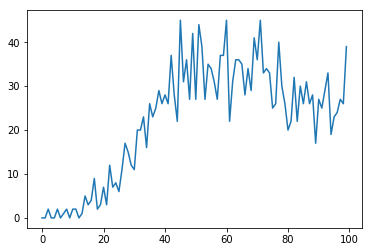

In [56]:
plt.plot(range(tmax), fmd[4][:100])

In [54]:
fmd

(160.51,
 array([38250., 25500., 38250., ...,     0.,     0.,     0.]),
 283,
 array([0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 4.000e+00,
        4.000e+00, 5.000e+00, 7.000e+00, 7.000e+00, 9.000e+00, 1.100e+01,
        1.100e+01, 1.200e+01, 1.700e+01, 2.000e+01, 2.400e+01, 3.300e+01,
        3.500e+01, 3.800e+01, 4.500e+01, 4.800e+01, 6.000e+01, 6.700e+01,
        7.500e+01, 8.100e+01, 9.200e+01, 1.090e+02, 1.240e+02, 1.360e+02,
        1.470e+02, 1.670e+02, 1.870e+02, 2.100e+02, 2.260e+02, 2.520e+02,
        2.750e+02, 3.000e+02, 3.290e+02, 3.550e+02, 3.830e+02, 4.090e+02,
        4.460e+02, 4.740e+02, 4.960e+02, 5.410e+02, 5.720e+02, 6.080e+02,
        6.350e+02, 6.770e+02, 7.040e+02, 7.480e+02, 7.870e+02, 8.140e+02,
        8.490e+02, 8.830e+02, 9.140e+02, 9.410e+02, 9.780e+02, 1.015e+03,
        1.060e+03, 1.082e+03, 1.113e+03, 1.149e+03, 1.185e+03, 1.220e+03,
        1.248e+03, 1.282e+03, 1.311e+03, 1.352e+03, 1.388e+03, 1.433e+03,
        1.466e+03, 1.500e+03, 1.53